# 1 - OPES expanded
We use [OPES_EXPANDED](https://www.plumed.org/doc-v2.8/user-doc/html/_o_p_e_s__e_x_p_a_n_d_e_d.html) to sample expanded (or generalized) ensembles.
</br>
The system is solid/superionic NH3.

In [1]:
root_path = '../' #change this if you move the nootebook somewhere else

import pandas
import numpy as np
import plumed

import sys
sys.path.append(root_path + 'scripts') #dirty way to import our script
from calcFES import calcFES, calcDeltaF, calcESS

%matplotlib notebook

In [2]:
#reuse same plumed kernel, to avoid multiple warnings
PLUMED_KERNEL=plumed.Plumed()
from functools import partial
plumed.read_as_pandas = partial(plumed.read_as_pandas, kernel=PLUMED_KERNEL)

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/m100/home/userexternal/cmalosso/plumed2/build_2.8.1/lib/libplumedKernel.so" +++


In [3]:
#plot-related stuff
import matplotlib.pyplot as plt
from IPython.display import clear_output

#set bigger font sizes
SMALL_SIZE = 11
MEDIUM_SIZE = 12
BIG_SIZE = 15
plt.rc('font', size=SMALL_SIZE)        # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)   # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)   # fontsize of the figure title

try:
# https://github.com/luigibonati/fessa-color-palette/blob/master/fessa.py
    import fessa
    plt.set_cmap('fessa')
except:
    pass # no big deal

In [4]:
#useful constants for our simulations
KB = 0.0083144621
T0 = 900
P0 = 0.06022140857*9e5
BETA0 = 1/(KB*T0)
KBT = KB*T0

## 1.1 - Multithermal-multibaric simulations

In [5]:
folder = root_path + '../../mtmb_80-100GPa_500-1400K/'

try:
    colvar = plumed.read_as_pandas(folder+'COLVAR')
except: # are you using multiple walkers?
    #!cat {folder}/COLVAR* > {folder}COLVAR
    !sort -gk1 {folder}/COLVAR* > {folder}COLVAR
    colvar = plumed.read_as_pandas(folder+'COLVAR')
    !rm {folder}COLVAR
time = colvar['time'].to_numpy()/1000 #convert from ps to ns
deltaFs = plumed.read_as_pandas(folder+'DeltaFs.data')

print_old = False
#compare to another run
#folder_old = root_path + '1-opes_expanded/multithermal/'
#print_old = (folder_old != folder)
#if print_old:
#    deltaFs_old = plumed.read_as_pandas(folder_old+'DELTAFS')

<IPython.core.display.Javascript object>


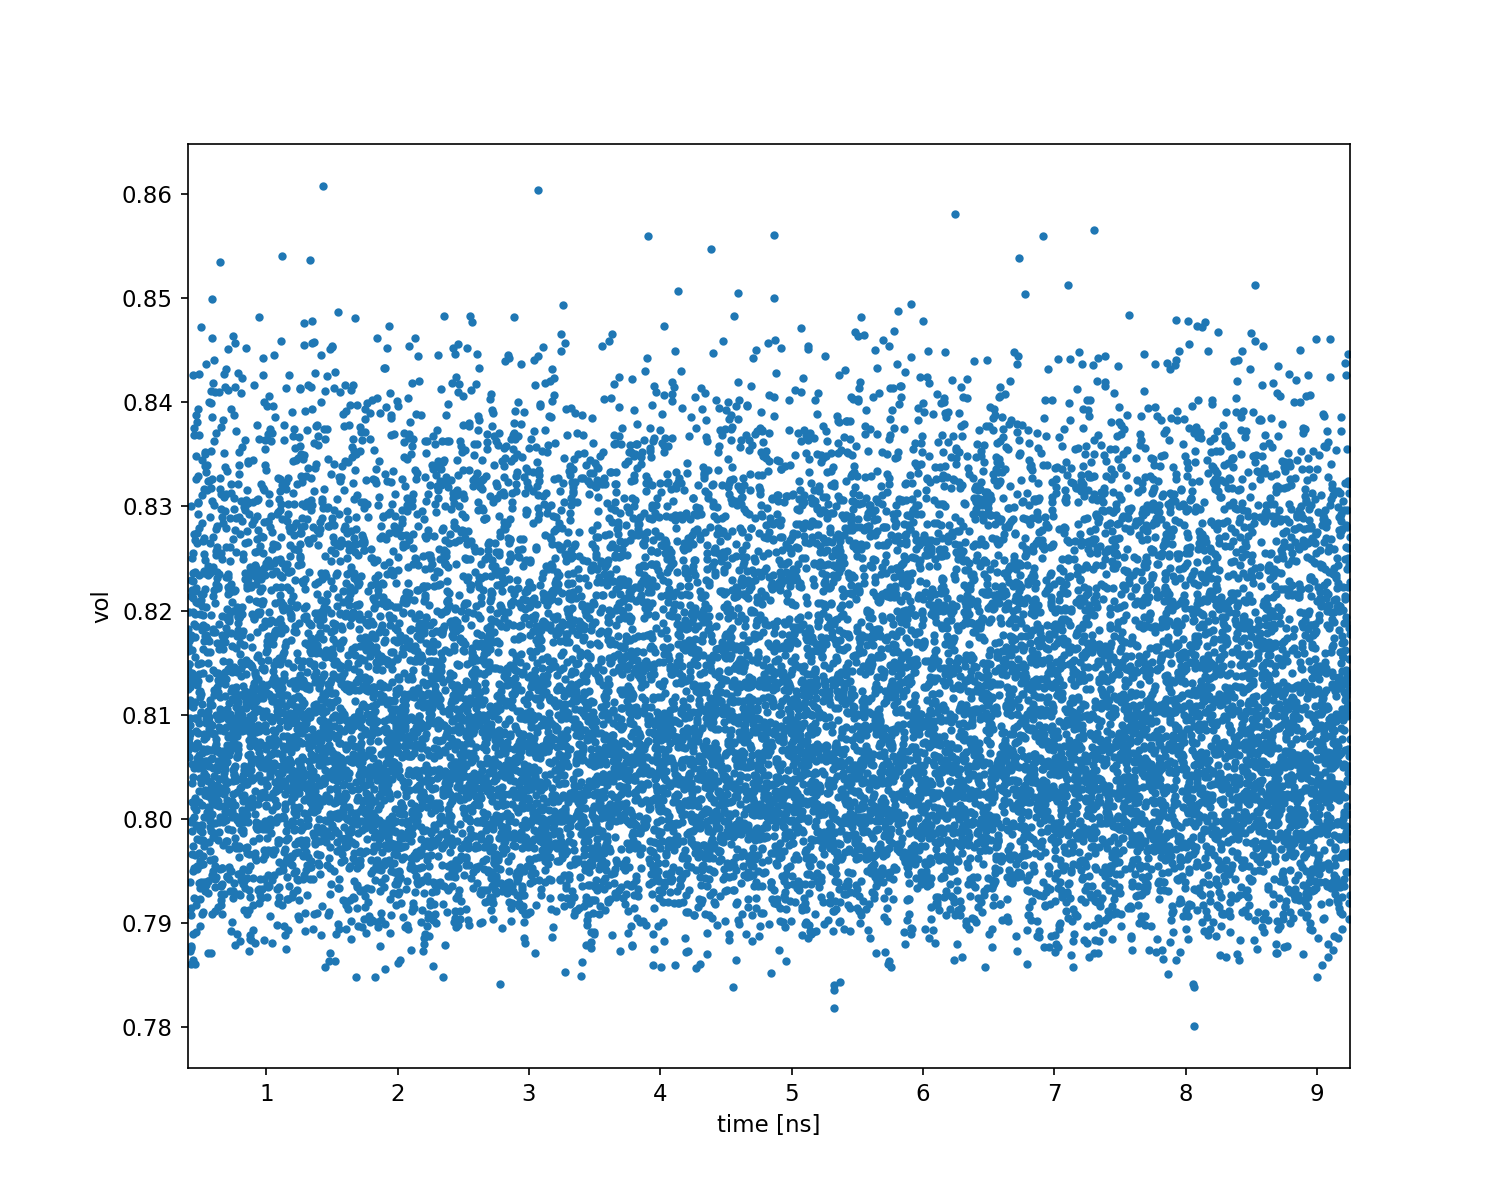

(0.4, 9.25)

In [6]:
#plot volume
fig, ax = plt.subplots(1, figsize=(10,8))
plt.plot(time[::100], colvar['vol'][::100], '.')
plt.ylabel('vol')
plt.xlabel('time [ns]')
plt.xlim(time[0], time[-1])

<IPython.core.display.Javascript object>


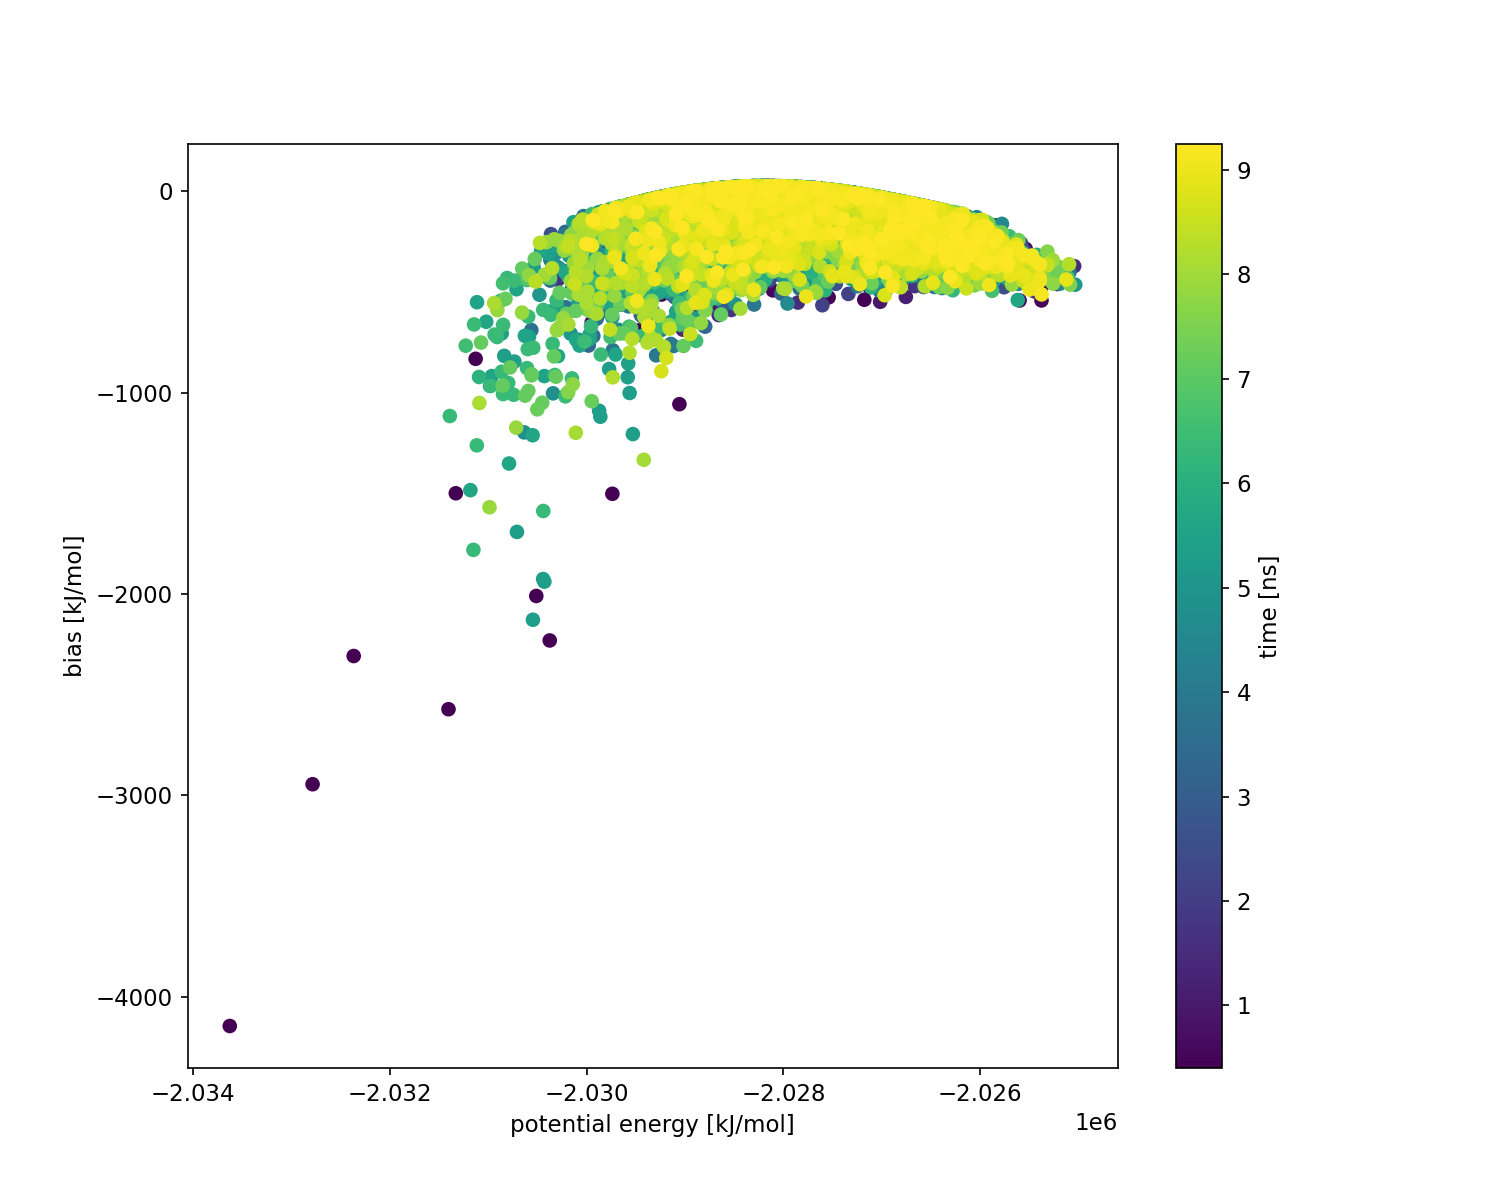

In [7]:
#plot bias
fig, ax = plt.subplots(1, figsize=(10,8))
plt.scatter(colvar['energy'][::100], colvar['opes.bias'][::100], c=time[::100])
plt.ylabel('bias [kJ/mol]')
plt.xlabel('potential energy [kJ/mol]')
plt.colorbar(label='time [ns]')

<IPython.core.display.Javascript object>


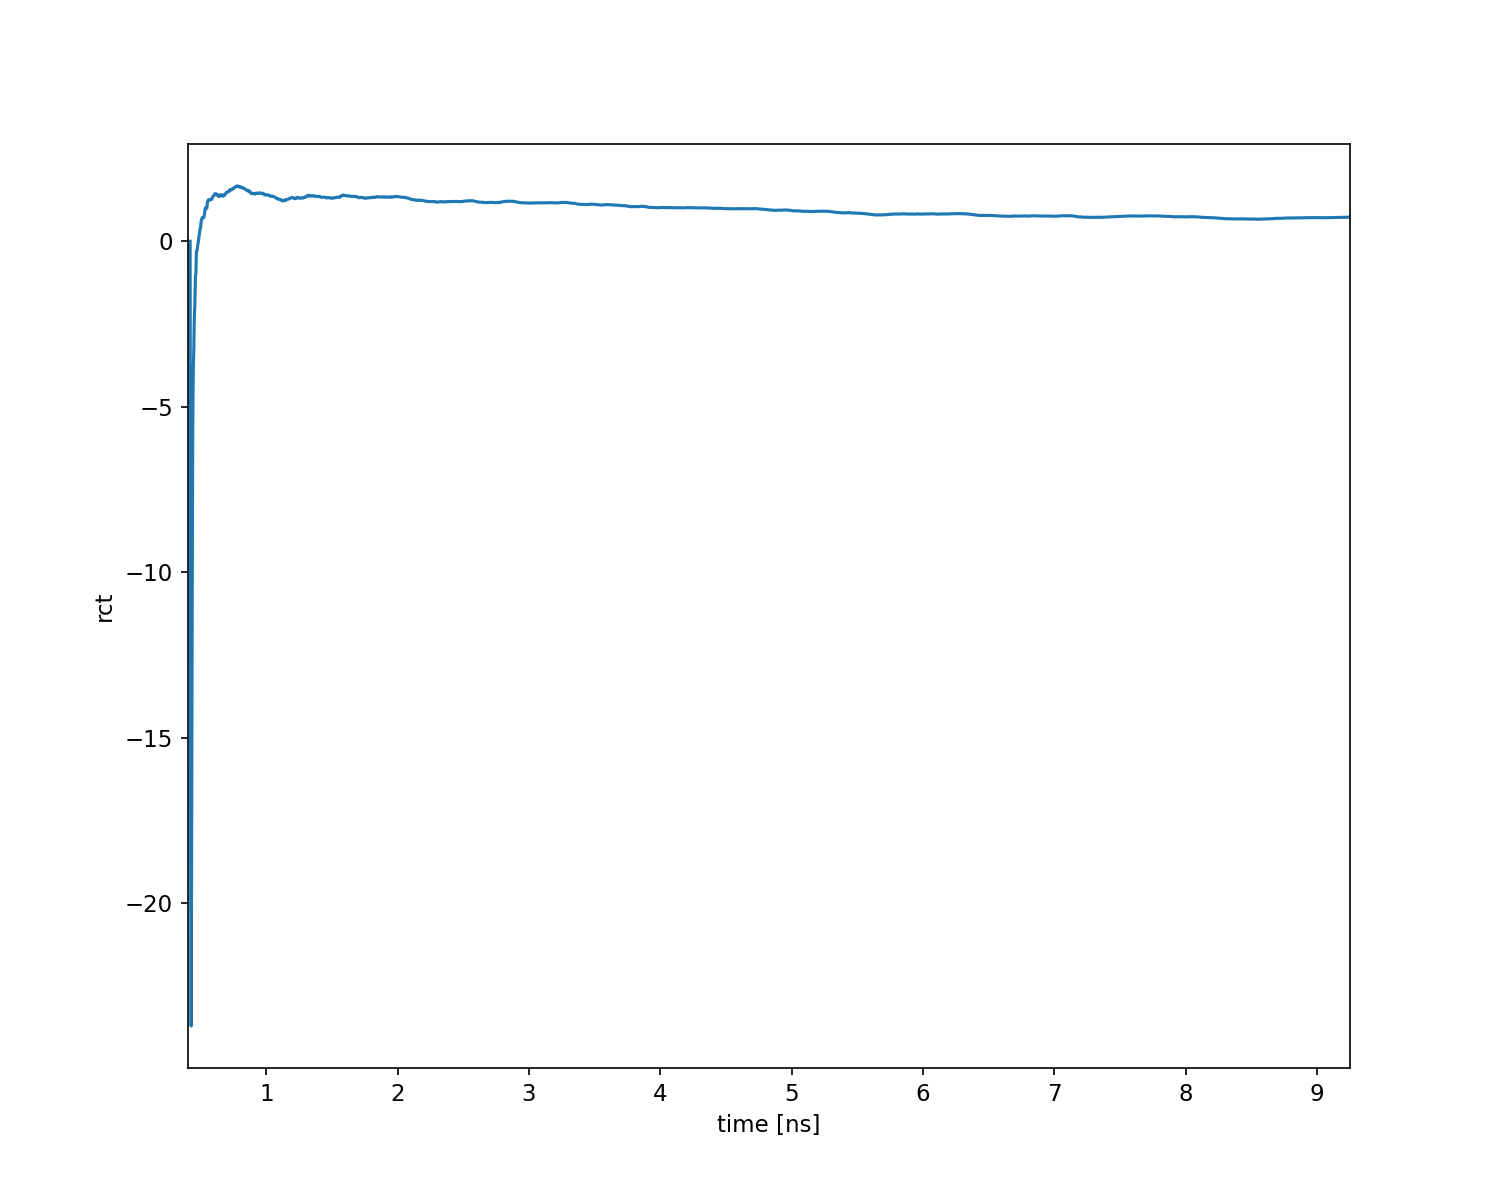

In [8]:
#plot rct
fig, ax = plt.subplots(1, figsize=(10,8))

ax.plot(deltaFs['time']/1000, deltaFs['rct'])
plt.ylabel('rct')
plt.setp(ax, xlabel='time [ns]', xlim=(time[0], time[-1]))
plt.show()

We can quantify the efficiency of our multithermal simulation, by plotting the **effective sample size** (ESS or $n_{\text{eff}}$) as a function of temperature:
$$ n_{\text{eff}} = \frac{\left[\sum_k^n w_k\right]^2}{\sum_k^n w_k^2}$$
where $w_k=w_T(U(x_k))w_V(U(x_k))$ are the reweighting weights. For nonuniform weights $0<n_{\text{eff}}<n$. The ratio between the effective sample size and the number of samples $n$ give us a first estimate of how good the sampling is.
However, this is only the loss in efficiency due to the importance sampling. Another efficiency loss comes from the fact that MD samples are correlated. This can be taken into account e.g. by a block average analysis. This will help you quantify if your simulation makes enough transitions between the metastable states.

OPES_EXPANDED calculates the $n_{\text{eff}}$ of the first few steps (`OBSERVATION_STEPS=100` by default) in order to automatically choose the number of `TEMP_STEPS` to use for the expansion.

In [36]:
p=0.06022140857*9e5 # we want to see the effective sampling at the same pressure of the lammps NPT simulation p=90GPa

<IPython.core.display.Javascript object>


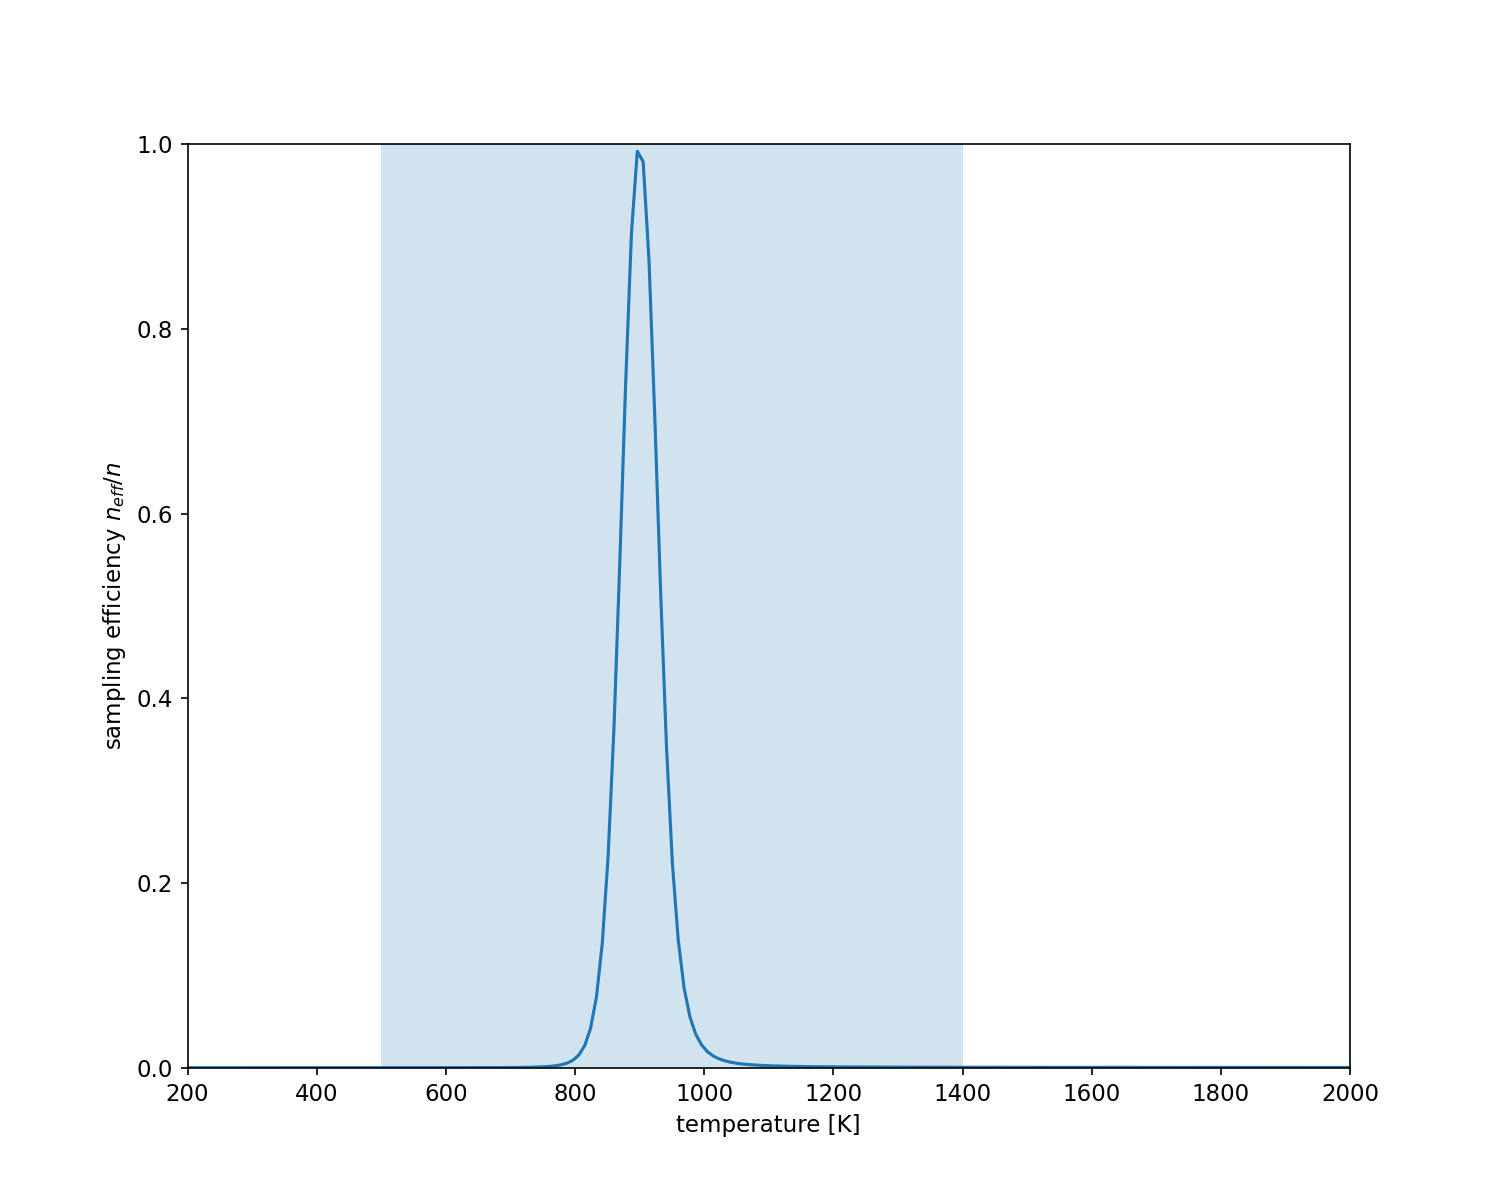

In [37]:
# calculate ESS of the initial unbiased samples
temp_min = 500
temp_max = 1400
temp_steps = 16
temps = np.linspace(200, 2000, 200)

start = len(np.where(colvar['opes.bias']==0)[0]) #only at the beginning the bias is perfectly zero
ESSs_start = np.array([calcESS(colvar['opes.bias'][:start]*BETA0+(1-T0/t)*colvar['energy'][:start]/KBT+(BETA0*P0 - p/(KB*t))*colvar['vol'][:start]) for t in temps])

fig, ax = plt.subplots(1, figsize=(10,8))
plt.plot(temps, ESSs_start/start)
plt.ylabel('sampling efficiency $n_{eff}/n$')
plt.xlabel('temperature [K]')
plt.xlim(temps[0], temps[-1])
plt.ylim(0, 1)
plt.axvspan(temp_min, temp_max, alpha=0.2)

transient = 161348


<IPython.core.display.Javascript object>


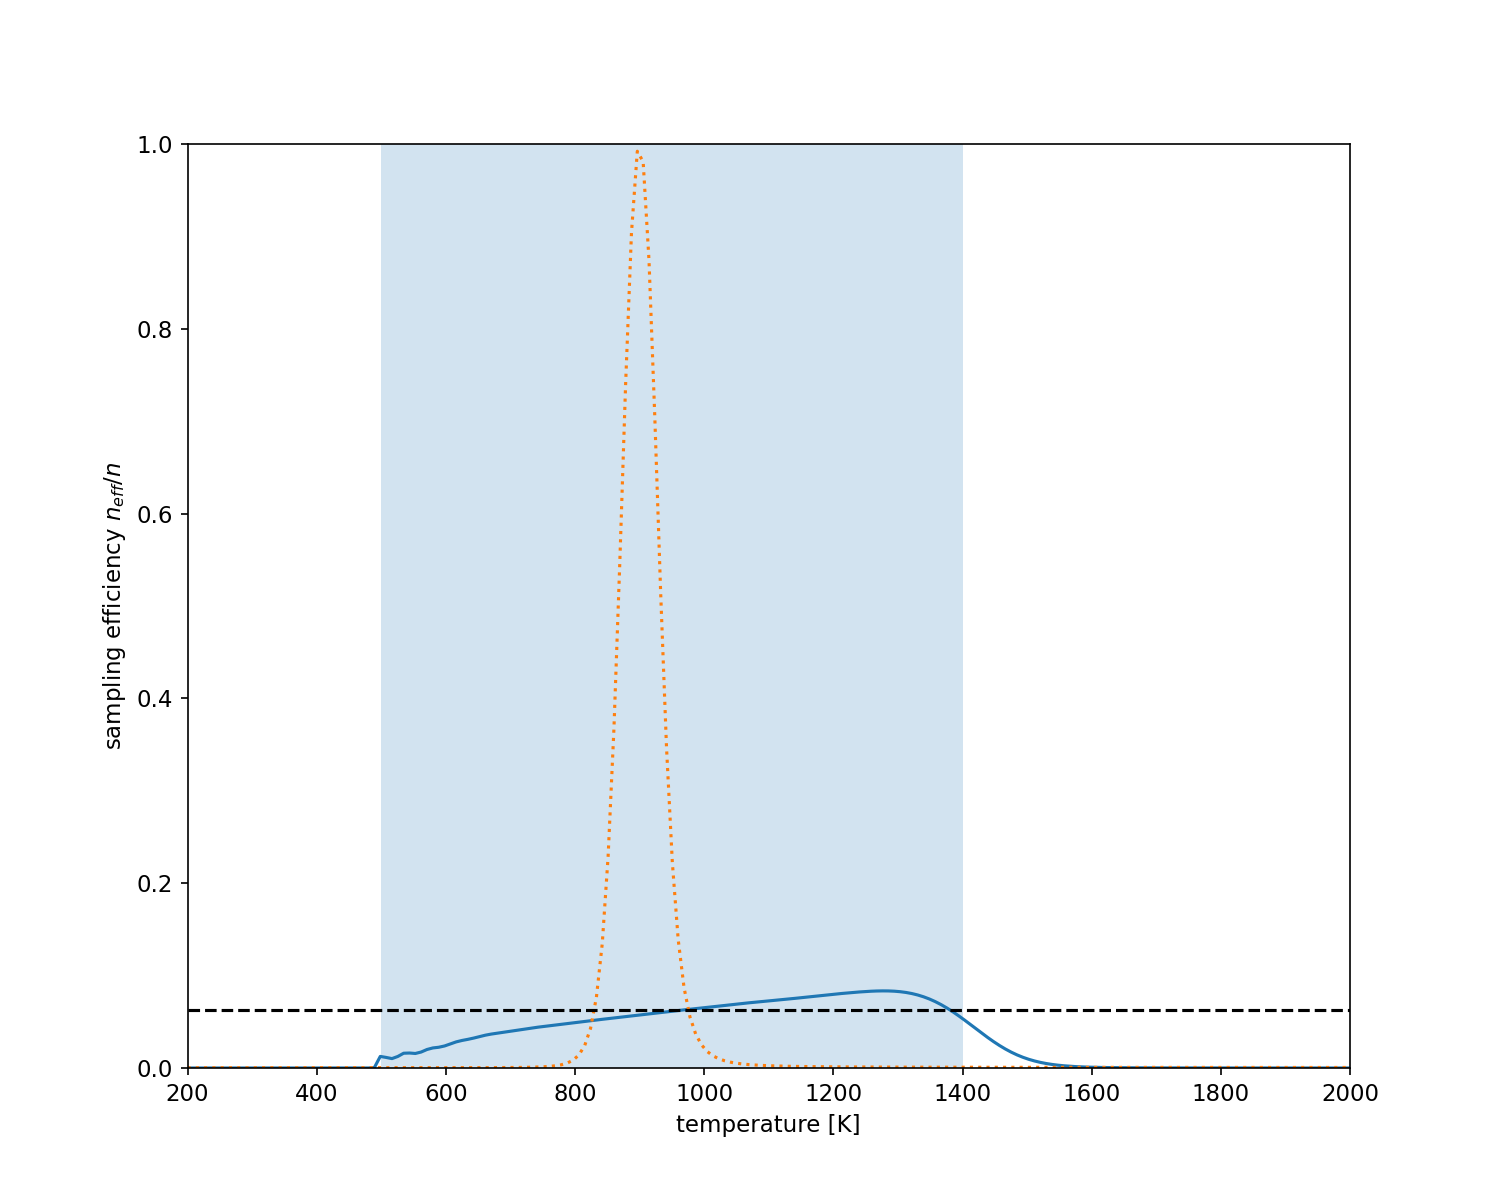

In [38]:
#plot effective sample size as a function of temperature
transient = len(colvar['opes.bias'])//10
#start
print('transient =', transient)

ESSs = np.array([calcESS(colvar['opes.bias'][transient:]*BETA0+(1-T0/t)*colvar['energy'][transient:]/KBT+(BETA0*P0 - p/(KB*t))*colvar['vol'][transient:]) for t in temps])

fig, ax = plt.subplots(1, figsize=(10,8))
plt.plot(temps, ESSs/(len(colvar['time'][transient:])))
plt.plot(temps, ESSs_start/start, ls=':')
plt.ylabel('sampling efficiency $n_{eff}/n$')
plt.xlabel('temperature [K]')
plt.xlim(temps[0], temps[-1])
plt.ylim(0, 1)
plt.axvspan(temp_min, temp_max, alpha=0.2)
plt.axhline(1/temp_steps, ls='--', c='k')

#plot the sampled energy distribution
#plt.hist(colvar['energy'][transient:], bins=50)
#plt.xlabel('potential energy [kJ/mol]')

transient = 161348


<IPython.core.display.Javascript object>


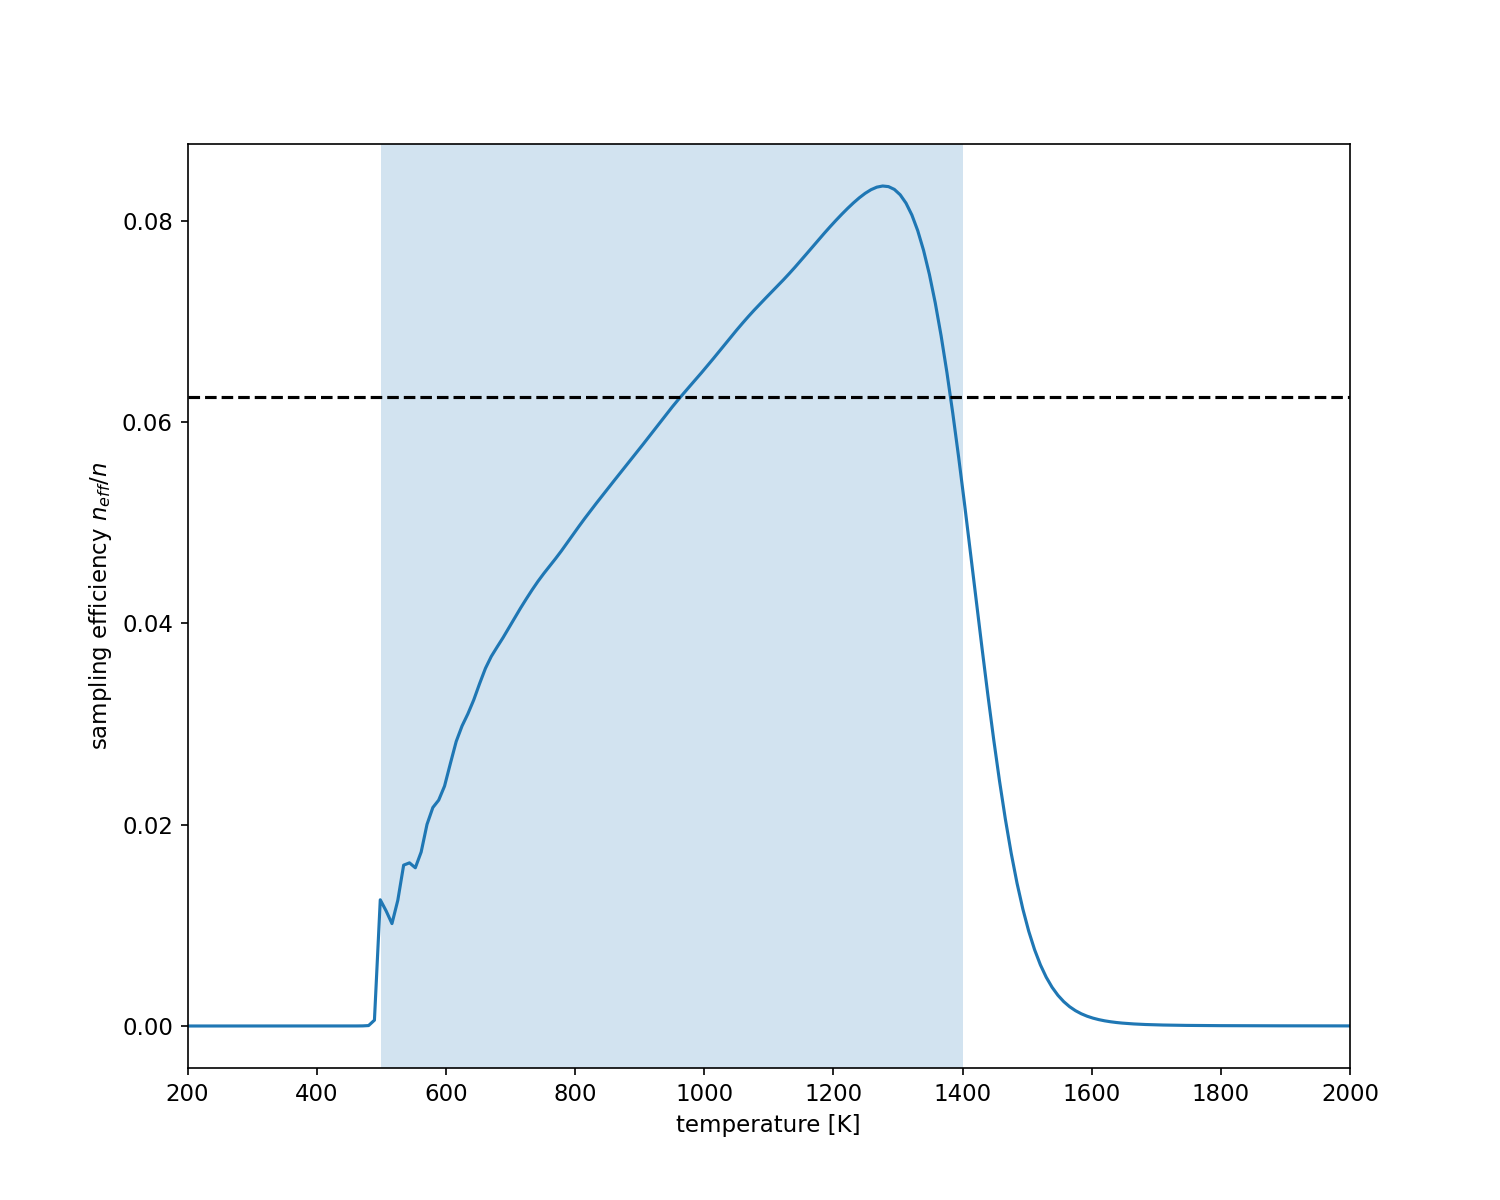

In [39]:
#plot effective sample size as a function of temperature
transient = len(colvar['opes.bias'])//10 #start
print('transient =', transient)

fig, ax = plt.subplots(1, figsize=(10,8))
plt.plot(temps, ESSs/(len(colvar['time'][transient:])))
plt.ylabel('sampling efficiency $n_{eff}/n$')
plt.xlabel('temperature [K]')
plt.xlim(temps[0], temps[-1])
plt.axvspan(temp_min, temp_max, alpha=0.2)
plt.axhline(1/temp_steps, ls='--', c='k')


#plot the sampled energy distribution
#plt.hist(colvar['energy'][transient:], bins=50)
#plt.xlabel('potential energy [kJ/mol]')

In [6]:
transient = 100000 #len(colvar['opes.bias'])//10 #start
p=0.06022140857*9e5
temps = np.linspace(500, 1400, 1100)

In [ ]:
energy = {}
volume = {}

for pp in [8e5,8.5e5,9e5,9.5e5,1e6]:
    energy[pp] = np.zeros(len(temps))
    volume[pp] = np.zeros(len(temps))
#    logweights = np.zeros((len(temps),colvar['opes.bias'][transient:].shape[0]))
    for i,t in enumerate(temps):
        temperature=900 # K
        newTemperature=t
        pressure=p
        newPressure=0.0602214086*pp
        kb=0.00831446 # kJ/mol/K
        beta=1./(kb*temperature)
        newBeta=1./(kb*newTemperature)
        logweights=beta*colvar['opes.bias'][transient:]+(beta-newBeta)*colvar['energy'][transient:]+(beta*pressure-newBeta*newPressure)*colvar['vol'][transient:]
        logweights -= np.amax(logweights)
        energy[pp][i] = np.sum(colvar['energy'][transient:]*np.exp(logweights))/np.sum(np.exp(logweights))
        volume[pp][i] = np.sum(colvar['vol'][transient:]*np.exp(logweights))/np.sum(np.exp(logweights))

    

In [13]:
energy = {}
volume = {}

for pp in [8e5,8.5e5,9e5,9.5e5,1e6]:
    logweights = np.zeros((len(temps),colvar['opes.bias'][transient:].shape[0]))
    for i,t in enumerate(temps):
        temperature=900 # K
        newTemperature=t
        pressure=p
        newPressure=0.0602214086*pp
        kb=0.00831446 # kJ/mol/K
        beta=1./(kb*temperature)
        newBeta=1./(kb*newTemperature)
        logweights[i]=beta*colvar['opes.bias'][transient:]+(beta-newBeta)*colvar['energy'][transient:]+(beta*pressure-newBeta*newPressure)*colvar['vol'][transient:]
        logweights[i] -= np.amax(logweights[i])
    energy[pp] = np.zeros(len(temps))
    volume[pp] = np.zeros(len(temps))
    for i,t in enumerate(temps):
        energy[pp][i] = np.sum(colvar['energy'][transient:]*np.exp(logweights[i]))/np.sum(np.exp(logweights[i]))
        volume[pp][i] = np.sum(colvar['vol'][transient:]*np.exp(logweights[i]))/np.sum(np.exp(logweights[i]))
    

KeyboardInterrupt: 

In [9]:
#logweights = np.zeros((len(temps),colvar['opes.bias'][transient:].shape[0]))
#for i,t in enumerate(temps):
#    logweights[i] = colvar['opes.bias'][transient:]*BETA0 
#    + (1-T0/t) * colvar['energy'][transient:]/KBT
#    + ( BETA0*P0 - p/(KB*t) ) * colvar['vol'][transient:]
#for i,t in enumerate(temps):
#    logweights[i] -= np.amax(logweights[i])

In [11]:
logweights

array([[-258.34254455, -457.07689   , -228.62239547, ..., -220.16406074,
        -118.16793484,  -43.12695188],
       [-256.59975835, -454.82442217, -226.9942262 , ..., -218.57041548,
        -116.99227628,  -42.73940272],
       [-254.86266236, -452.57930866, -225.37137293, ..., -216.98197349,
        -115.82045626,  -42.35311891],
       ...,
       [ -12.89409155,  -11.38113123,  -28.20545124, ...,  -33.3111509 ,
         -95.53658072, -330.13356653],
       [ -12.97132107,  -11.39312944,  -28.29734995, ...,  -33.40746814,
         -95.68639375, -330.38424531],
       [ -13.05214571,  -11.40879907,  -28.39282661, ...,  -33.50735817,
         -95.83971698, -330.63831627]])

In [12]:
energy = np.zeros(len(temps))
volume = np.zeros(len(temps))

for i,t in enumerate(temps):
    energy[i] = np.sum(colvar['energy'][transient:]*np.exp(logweights[i]))/np.sum(np.exp(logweights[i]))
    volume[i] = np.sum(colvar['vol'][transient:]*np.exp(logweights[i]))/np.sum(np.exp(logweights[i]))

In [9]:
energy95GPa = energy
volume95GPa = volume

In [51]:
energy100GPa

array([-2030520.40894648, -2030457.37100325, -2030398.0287874 , ...,
       -2026007.34824845, -2026005.90533316, -2026004.46493693])

<IPython.core.display.Javascript object>


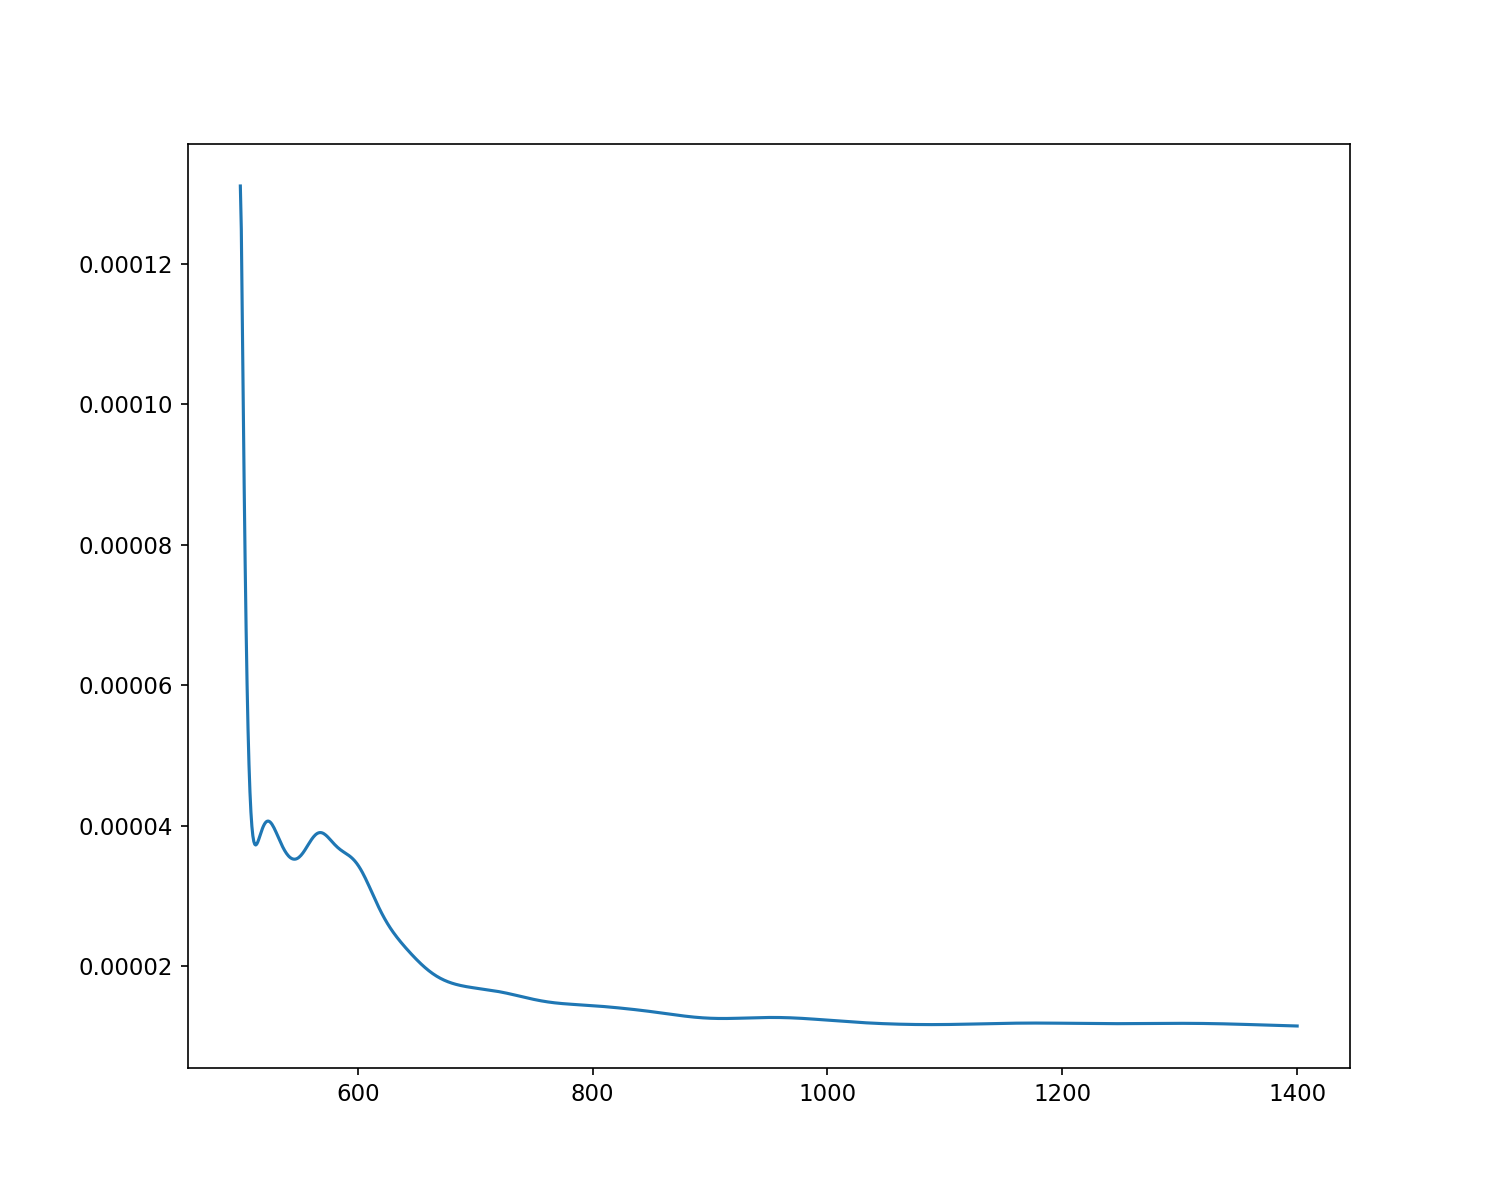

In [49]:
fig, ax = plt.subplots(1, figsize=(10,8))

for pp in [8e5,8.5e5,9e5,9.5e5,1e6]:
    ax.plot(temps,energy[pp], label = '{} bar'.format(pp))

In [15]:
c = np.gradient(energy,1)

In [16]:
np.size(energy)

1100

In [ ]:
colvar['vol'] -= 0.776669

In [16]:
colvar['energy'] += 2028461.0276412915

In [26]:
c = np.gradient(energy,1)

<IPython.core.display.Javascript object>


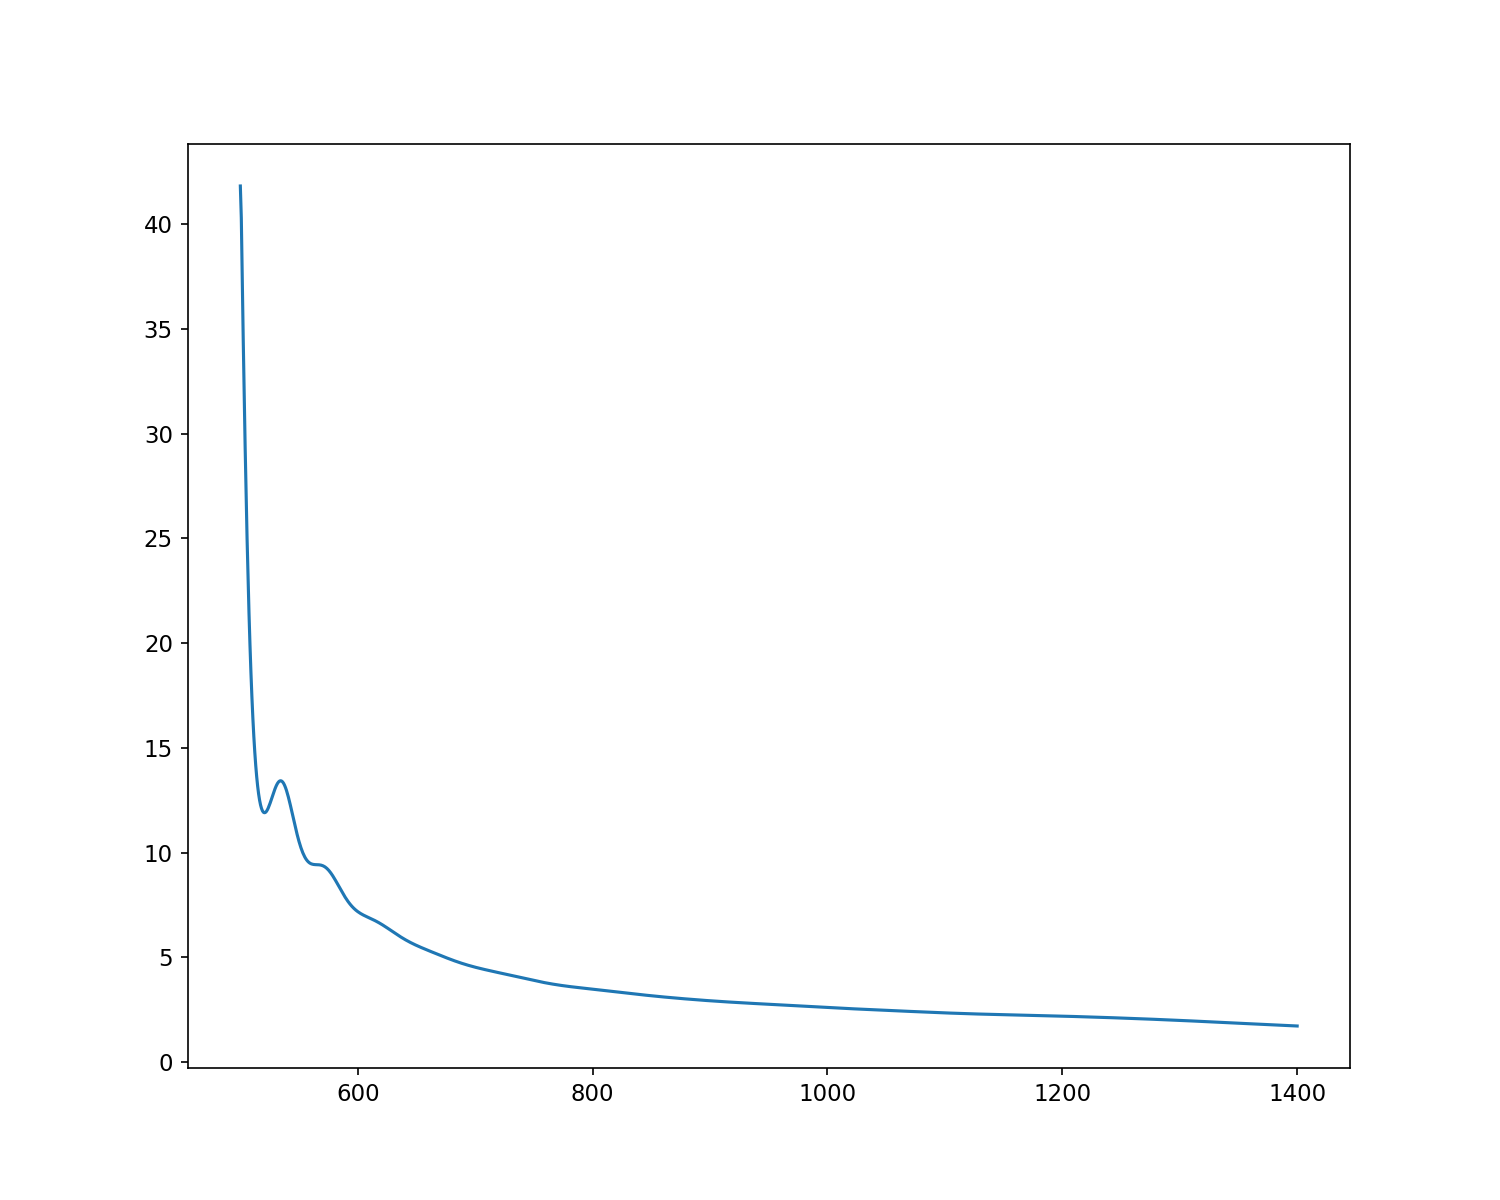

In [27]:
fig, ax = plt.subplots(1, figsize=(10,8))

ax.plot(temps,c)

In [28]:
d = np.gradient(volume,1)

<IPython.core.display.Javascript object>


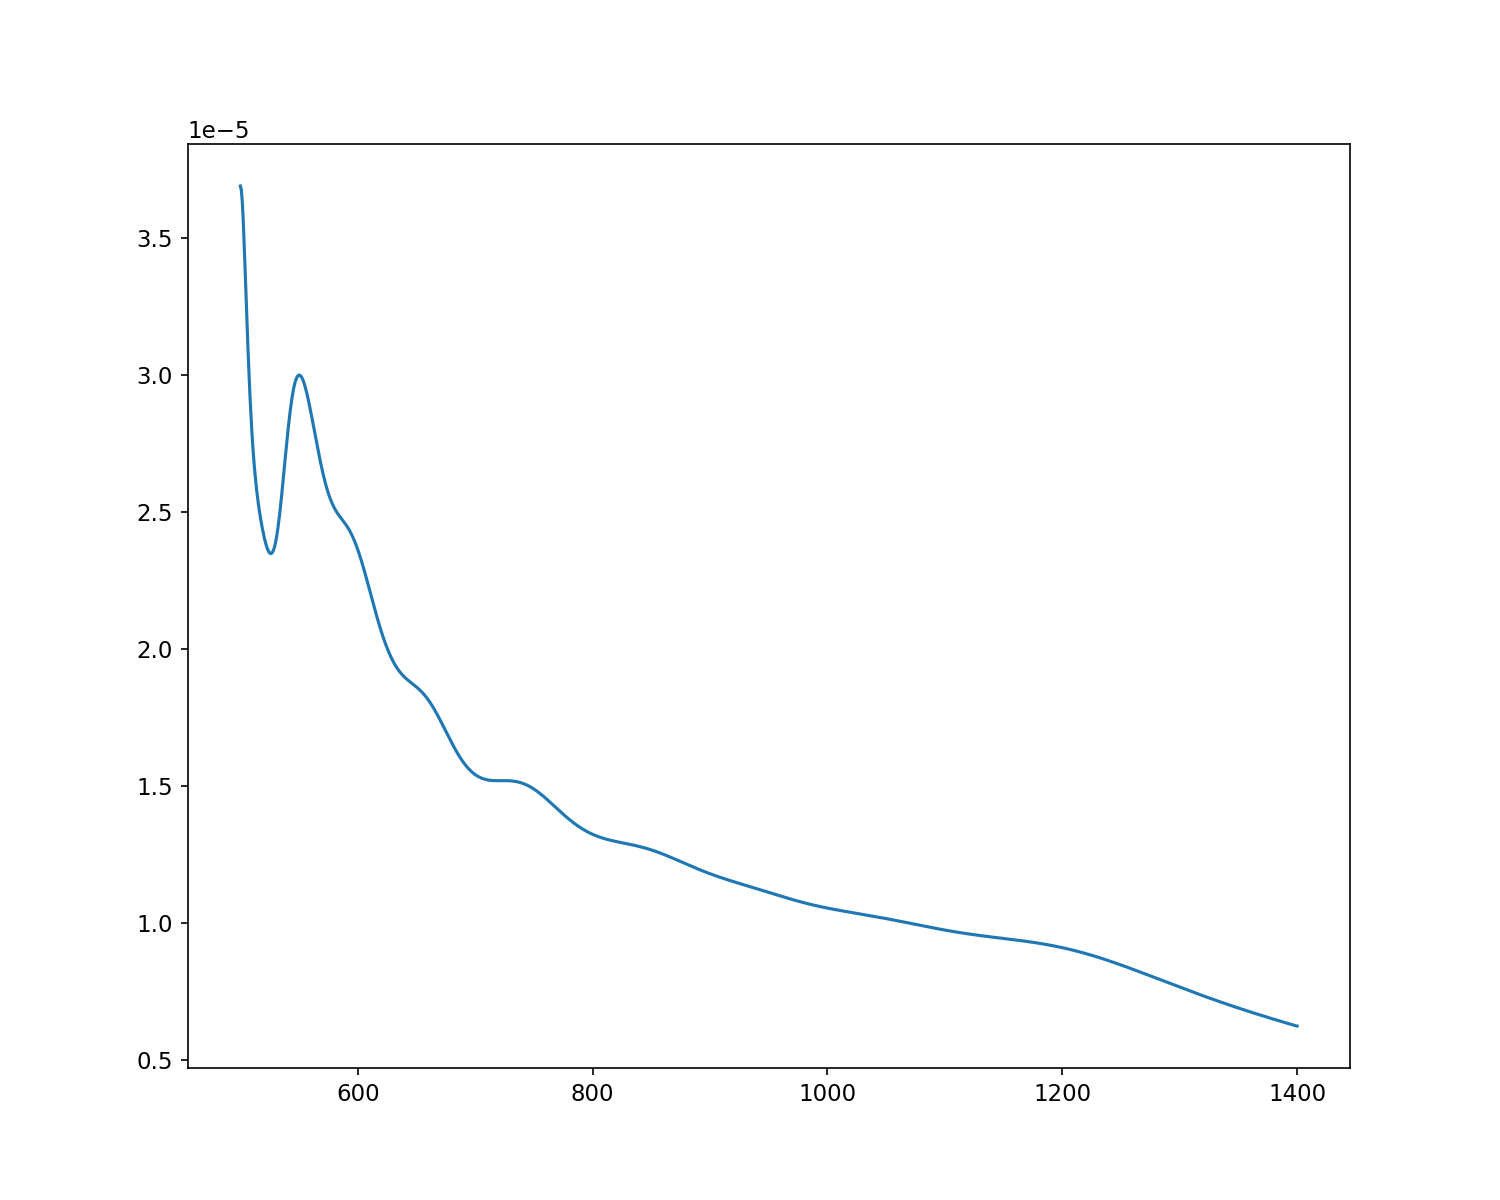

In [30]:
fig, ax = plt.subplots(1, figsize=(10,8))

ax.plot(temps,d)